In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, Image
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from datetime import datetime

# Steuerung versus Regelung

## Hausklimatisierung

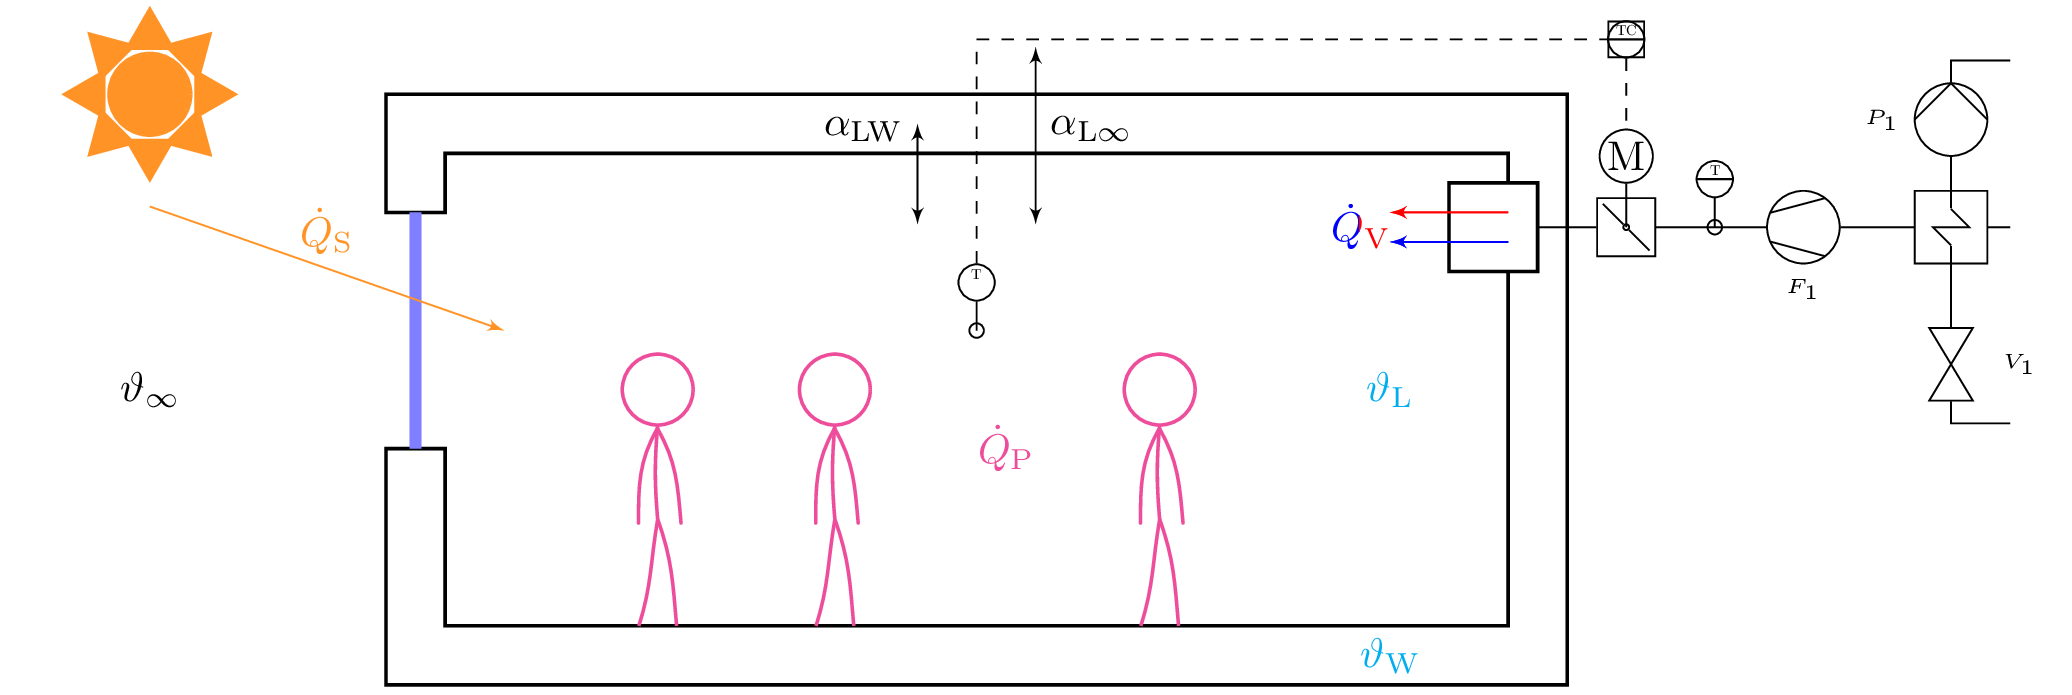

In [2]:
imag = Image("images/house.png")
display(imag)

### Vergleich

In [3]:
# Simulation von 06:00 bis 18:00
tSim = np.linspace(0, 43200, 4321)
time = np.array([datetime.fromtimestamp(item + 21600) for item in tSim])

In [4]:
cpL = 1183 # J / K - Wärmekapazität Luft
cpW = 4005 # J / K - Wärmekapazität Wand
alphaLW = 2.74 # W / K - Wärmewiderstand Luft-Wand
alphaLA = 0.456 # W / K - Wärmewiderstand Luft-Umgebung
Aw = 2.866 # m2 - Fensterfläche
p = 0.08 # - Fensterflächenanteil, der Wand beeinflusst

A = np.array([[-alphaLW / cpL - alphaLA / cpL, alphaLW / cpL],
              [alphaLW / cpW ,  - alphaLW / cpW]])
B = np.array([[alphaLA / cpL, 1 / cpL, Aw * (1 - p) / cpL, 1 / cpL],
              [0, 0, Aw * p / cpW , 0]])

In [5]:
class ReglerPID:
    def __init__(self, setPoint, P, I, D, outMin, outMax, sampleTime):
        self.P = P
        self.I = I
        self.D = D
        self.setPoint = setPoint
        self.outMin = outMin
        self.outMax = outMax
        self.sampleTime = sampleTime
        self.e = 0
        self.int = 0

    def regel(self, curValue):
        e = self.setPoint - curValue

        intStep = (e + self.e) * self.sampleTime
        diffStep = (e - self.e) / self.sampleTime

        out = (self.P * e +
               self.I * (self.int + intStep) / 2.0 +
               self.D * diffStep)

        if out < self.outMin:
            out = self.outMin
        elif out > self.outMax:
            out = self.outMax
        else:
            self.int += intStep

        self.e = e

        return out

In [6]:
x0 = [23, 23]
Ta=23.; QP=1.; QS=1.; QV=0.
thetaLSoll = 23
u = lambda t: [Ta, 
               0.7 * QP if 25200 < t < 32400 else 0,
               np.sin(np.pi * t / tSim[-1]) * QS, 
               QV]

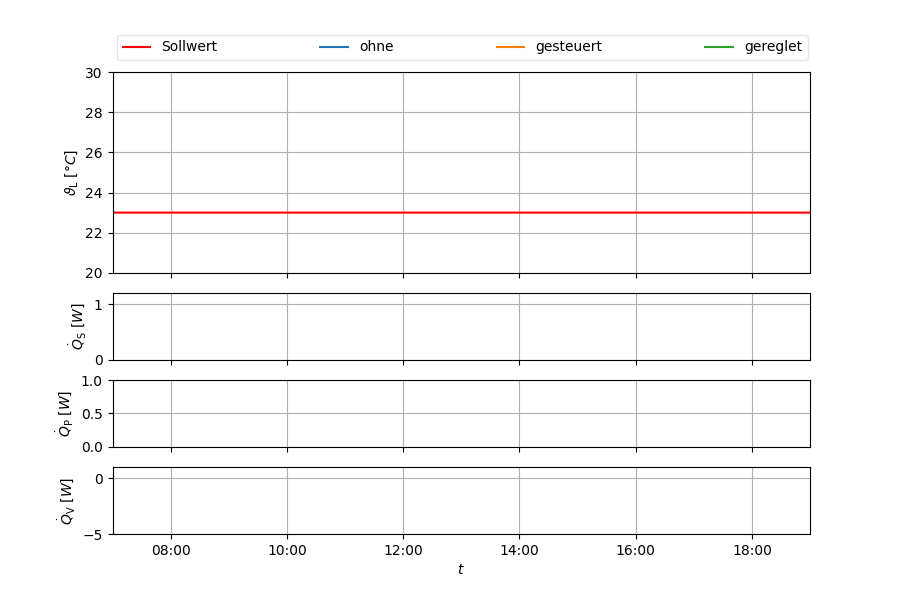

In [7]:
output = widgets.Output()

with output:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(9, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax1.set_xlim([time[0], time[-1]]); ax2.set_xlim([time[0], time[-1]]); ax3.set_xlim([time[0], time[-1]]); ax4.set_xlim([time[0], time[-1]]);
ax1.set_ylim([20, 30]); ax2.set_ylim([0, 1.2]); ax3.set_ylim([0, 1]); ax4.set_ylim([-5, 1])
ax1.grid(); ax2.grid(); ax3.grid(); ax4.grid()
ax4.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\vartheta_{\mathrm{L}}\ [°C]$")
ax2.set_ylabel(r"$\dot{Q}_{\mathrm{S}}\ [W]$")
ax3.set_ylabel(r"$\dot{Q}_{\mathrm{P}}\ [W]$")
ax4.set_ylabel(r"$\dot{Q}_{\mathrm{V}}\ [W]$")
ax1.plot(time, np.ones(len(tSim)) * thetaLSoll, label=r'Sollwert', c='r')
lineLOhne, = ax1.plot([], [], label=r'ohne')
lineLSteuerung, = ax1.plot([], [], label=r'gesteuert')
lineLRegler, = ax1.plot([], [], label=r'gereglet')
lineQS, = ax2.plot([], [])
lineQP, = ax3.plot([], [])
lineQVOhne, = ax4.plot([], [])
lineQVSteuerung, = ax4.plot([], [])
lineQVRegler, = ax4.plot([], [])
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

handlesAx, labelsAx = ax1.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.13, 0.9, 0.7675, .15), loc=3,
           ncol=4, mode="expand", borderaxespad=0., framealpha=0.5)

playB = widgets.Play(value=0,
                     min=0, 
                     max=len(tSim),
                     step=10)
sliderB = widgets.IntSlider(value=0,
                            min=0,
                            max=len(tSim),
                            step=10)
                                         
def updateOhne(_):
    global resOhne
    
    def Haus(t, x, u, A, B):
        return A @ x + B @ u(t)
    
    resOhne = solve_ivp(Haus,
                        [tSim[0], tSim[-1]],
                        x0,
                        t_eval=tSim, args=(u, A, B))

def updateSteuerung(_):
    global resSteuerung
    global QVSteuerung
    
    def Haus(t, x, u, A, B):
        return A @ x + B @ u(t)
    
    uSteuerung = lambda t: [Ta, 
                            0.7 * QP if 25200 < t < 32400 else 0,
                            np.sin(np.pi * t / tSim[-1]) * QS, 
                            -0.11 - Aw * (1 - p) * np.sin(np.pi * t / tSim[-1]) * QS]
    QVSteuerung = [uSteuerung(_t)[3] for _t in tSim]
    resSteuerung = solve_ivp(Haus,
                             [tSim[0], tSim[-1]],
                             x0,
                             t_eval=tSim, args=(uSteuerung, A, B))

def updateRegler(_):
    global x0
    global thetaRegler
    global QVRegler
    
    def Haus(t, x, u, A, B):
        
        return A @ x + B @ u(t)
    
    QVRegler = np.zeros(len(tSim))
    thetaRegler = np.zeros((2, len(tSim)))
    thetaRegler[:, 0] = x0
    regler = ReglerPID(thetaLSoll, 20, 0.5, 0, -20, 20, tSim[1])

    for idx, _t in enumerate(tSim[1:]):
        x0 = thetaRegler[:, idx]
        QVRegler[idx] = regler.regel(x0[0])
        uRegler = lambda t: [Ta,
                             0.7 * QP if 25200 < t < 32400 else 0,
                             np.sin(np.pi * t / tSim[-1]) * QS, 
                             QVRegler[idx]]
        res = solve_ivp(Haus,
                        [tSim[idx], tSim[idx + 1]],
                        x0,
                        args=(uRegler, A, B))
        thetaRegler[0, idx + 1] = res.y.T[-1, 0]
        thetaRegler[1, idx + 1] = res.y.T[-1, 1]

def updatePlot(change):
    idx = change['new']

    lineLOhne.set_data(time[:idx], resOhne.y.T[:idx, 0])
    lineLSteuerung.set_data(time[:idx], resSteuerung.y.T[:idx, 0])
    lineLRegler.set_data(time[:idx], thetaRegler[0, :idx])
    lineQP.set_data(time[:idx], [u(_t)[1] for _t in tSim[:idx]])
    lineQS.set_data(time[:idx], [u(_t)[2] for _t in tSim[:idx]])
    lineQVOhne.set_data(time[:idx], [u(_t)[3] for _t in tSim[:idx]])
    lineQVSteuerung.set_data(time[:idx], QVSteuerung[:idx])
    lineQVRegler.set_data(time[:idx], QVRegler[:idx])

    fig.canvas.draw()    

sliderB.observe(updatePlot, names='value')

updateOhne(_)
updateSteuerung(_)
updateRegler(_)

jslink((playB, 'value'), (sliderB, 'value'))
HBox([playB, sliderB])